# General Code

In [1]:
from manim import *
import matplotlib.pyplot as plt
import matplotlib as mpl

def fib_sequence(n):
    # iterates over all strings ...,'1211221', ... which sum to n
    if n == 0:
        yield ''
    elif n == 1:
        yield '1'
    else:
        for s in fib_sequence(n-1):
            yield '1' + s
        for s in fib_sequence(n-2):
            yield '2' + s
            
fib_num = [1, 1]
for _ in range(50):
    fib_num.append(fib_num[-1] + fib_num[-2])

TILE_SIZE = 0.5
        
class Omino(Square):
    def __init__(self):
        Square.__init__(self, side_length = TILE_SIZE, fill_opacity = 1, fill_color = RED, stroke_color = WHITE)
        
class Domino(Rectangle):
    def __init__(self):
        Rectangle.__init__(self, height = TILE_SIZE, width = 2 * TILE_SIZE, fill_opacity = 1, fill_color = BLUE, stroke_color = WHITE)
        
class TilePile(VGroup):
    def __init__(self, tile_type, num_tiles = 30):
        self.tile_type = tile_type
        VGroup.__init__(self, *[tile_type().shift(TILE_SIZE * (RIGHT * np.random.uniform(-1,1) + UP * np.random.uniform(-1,1))).rotate(np.random.uniform()) 
                                for _ in range(num_tiles)])
        self.index = 0
        
    def get_tile(self):
        self.index -= 1
        return self[self.index]
        
class FibTiling(VGroup):
    def __init__(self, n: int):
        VGroup.__init__(self)
        self.n = n
        self.background = Rectangle(height = TILE_SIZE, width = n * TILE_SIZE, fill_opacity=0, stroke_color = WHITE, stroke_width = 5)
        grid_lines = VGroup()
        top = self.background.get_corner(UP + LEFT)
        for i in range(1, n):
            top += TILE_SIZE * RIGHT
            grid_lines.add(Line(start = top, end = top + TILE_SIZE * DOWN, stroke_width = 3))
        self.background.add(grid_lines)
        self.add(self.background)
        self.piles = None
        
    def new_tile(self, length):
        if self.piles is None:
            return {1: Omino, 2: Domino}[length]()
        else:
            return self.piles[length].get_tile()
        
    def add_tiles(self, tile_string):
        self.lengths = [int(s) for s in tile_string]
        assert sum(self.lengths) == self.n
        tiles = []
        self.animations = []
        for i, length in enumerate(self.lengths):
            tile = {1: Omino, 2: Domino}[length]()
            if i == 0:
                tile.align_to(self, LEFT + UP)
            else:
                tile.next_to(tiles[-1], RIGHT, buff=0)
            tiles.append(tile)
            if self.piles:
                self.animations.append(ReplacementTransform(self.piles[length].get_tile(), tile))
            else:
                self.animations.append(FadeIn(tile))
        self.tiles = VGroup(*tiles)
        self.add(self.tiles)


class FibTilings(VGroup):
    def __init__(self, n: int, piles = None):
        VGroup.__init__(self)
        self.n = n
        self.piles = piles
        tilings = []
        for s in fib_sequence(n):
            tiling = FibTiling(n)
            tiling.piles = piles
            tiling.add_tiles(s)
            tilings.append(tiling)
        self.tilings = VGroup(*tilings)
        self.tilings.arrange_in_grid(cols = 1)
        self.add(self.tilings)
        
    def play(self, scene, fast = True):
        if fast:
            scene.play(*[animation for tiling in self.tilings for animation in tiling.animations])
        else:
            for tiling in self.tilings:
                scene.add(tiling.background)
                scene.play(*tiling.animations)
            
    def add_label(self):
        brace = Brace(self.tilings, UP)
        text = brace.get_tex(f"F({self.n})={len(self.tilings)}")
#         text = brace.get_tex(f"{len(self.tilings)}")
        self.label = VGroup(brace, text)
        self.add(self.label)
        
    def recursive_tilings(self, i):
        if i == 1:
            start = 0
            end = fib_num[self.n - 1]
        if i == 2:
            start = fib_num[self.n - 1]
            end = fib_num[self.n]
        return self.tilings[start:end]
        
    def recursive_piece(self, i):
        tiles = VGroup()
        for tiling in self.recursive_tilings(i):
            tiles.add(tiling.tiles[1:])
        return tiles
    
    def create_recursively(self, scene, prev_tilings, fast=False):
        anims = []
        for i in range(2):
            piece = self.recursive_piece(i + 1)
            v = piece.get_center() - prev_tilings[i].get_center()
            piece.shift(-v)
            scene.add(piece)
            anims.append(piece.animate.shift(v))
            left_pieces = VGroup(*[tiling.tiles[0] for tiling in self.recursive_tilings(i + 1)])
            anims.append(FadeIn(left_pieces))
        if fast:
            scene.play(*anims)
        else:
            for anim in anims:
                scene.play(anim)
                
    def sum_groups(self):
        groups = VGroup(self.tilings[0])
        i = 1
        for j in fib_num[:self.n-1]:
            groups.add(self.tilings[i:i+j])
            i += j
        return groups

Manim Community v0.8.0

# Scene 1

In [27]:
%%manim -qh -v WARNING Scene1
# %%manim -n54 -qm -v WARNING Scene1
# %%manim -qh -v WARNING Test
# %%manim -n30 -qm -v WARNING Test

class Scene1(MovingCameraScene):
    def construct(self):        
        text1 = Tex(r'How many ways are there to tile a $1 \times 8$ block \\\ using $1 \times 1$ squares and $1 \times 2$ dominoes?')
        text1.to_corner(UP + LEFT)
        self.play(Create(text1))
        
        tiling = FibTiling(8)
        tiling.next_to(text1, direction = DOWN, buff = 1)
        omino_pile = TilePile(Omino, 54).to_corner(DOWN + LEFT)
        domino_pile = TilePile(Domino, 30).next_to(omino_pile)
        tiling.piles = {1: omino_pile, 2: domino_pile}
        
        self.play(FadeIn(omino_pile), FadeIn(domino_pile), Create(tiling.background), run_time=0.5)
        self.wait()
        
        for tile_string in ['1' * 8, '2' * 4, '21212', '21122', '112112']:
            tiling.add_tiles(tile_string)
            self.play(*tiling.animations)
            self.wait()
            self.play(FadeOut(tiling.tiles), run_time=0.2)
            
        text2 = Tex(r'Let $F(n)$ be the number of ways to tile a $1 \times n$ block')
        text2.next_to(tiling, direction = DOWN, buff = 1)
        text2.to_edge(LEFT)
        self.play(Create(text2))
        self.wait()
        self.play(FadeOut(tiling.background), FadeOut(text1), FadeOut(text2))
        
        tiling_groups = VGroup(*[FibTilings(n, tiling.piles) for n in range(1,6)])
        for g in tiling_groups:
            g.add_label()
        tiling_groups.arrange_in_grid(rows = 1, buff = 0.7, cell_alignment = UP)
        tiling_groups.shift(DOWN * 0.5)
        for g in tiling_groups:
            g.play(self, fast = g.n >= 4)
            self.play(Create(g.label))
            if g.n == 3:
                self.wait()
            
        self.wait(2)
        
        f0 = MathTex("F(0) = 1")
        f0.to_edge(LEFT)
        f0.shift(UP)
        self.play(Create(f0))
        
        self.wait(2)
        
        recurrence = MathTex("F(n)","=","F(n-1)","+","F(n-2)")
        recurrence.scale(1.5)
        recurrence.to_corner(LEFT + DOWN)
        self.play(Create(recurrence))
        
        self.play(*[Indicate(tiling_groups[-1].tilings[i].tiles[0]) for i in range(5)])
        self.play(*[Indicate(tiling_groups[-1].tilings[i].tiles[0]) for i in range(5, 8)])
        for tiling in tiling_groups[-1].tilings:
            tiling.remove(tiling.background)

        self.wait()
        
        rec_colors = [YELLOW, GREEN]
        rec_piece1 = tiling_groups[-1].recursive_piece(1)
        self.play(*[Indicate(tiling_groups[-1].tilings[i].tiles[0]) for i in range(5)], rec_piece1.animate.shift(RIGHT * 0.2))
        boxes1 = [rec_piece1, tiling_groups[-2].tilings, recurrence[2]]
        boxes1 = VGroup(*[SurroundingRectangle(box, buff = 0.1, color = rec_colors[0]) for box in boxes1])
        self.play(Create(boxes1))
        self.wait()
        rec_piece2 = tiling_groups[-1].recursive_piece(2)
        self.play(*[Indicate(tiling_groups[-1].tilings[i].tiles[0]) for i in range(5, 8)], rec_piece2.animate.shift(RIGHT * 0.2))
        boxes2 = [rec_piece2, tiling_groups[-3].tilings, recurrence[4]]
        boxes2 = VGroup(*[SurroundingRectangle(box, buff = 0.1, color = rec_colors[1]) for box in boxes2])
        self.play(Create(boxes2))
        self.wait(3)
        self.play(FadeOut(boxes1[0]), FadeOut(boxes2[0]), FadeOut(tiling_groups[-1]))
        self.wait()
        
        tiling_groups.remove(tiling_groups[-1])
        for n in range(5, 9):
            tiling_groups.add(FibTilings(n))
            tiling_groups[-1].move_to(tiling_groups[-2].tilings.get_corner(RIGHT + UP) + RIGHT, aligned_edge = LEFT + UP)
            if n > 5:
                box1 = SurroundingRectangle(tiling_groups[-2].tilings, buff = 0.1, color = rec_colors[0])
                box2 = SurroundingRectangle(tiling_groups[-3].tilings, buff = 0.1, color = rec_colors[1])
                self.play(ReplacementTransform(boxes1[1], box1), ReplacementTransform(boxes2[1], box2))
                boxes1[1], boxes2[1] = box1, box2
                anims = [self.camera.frame.animate.set_height(tiling_groups[-1].get_height() * 1.05 + 3).move_to(self.camera.frame.get_corner(UP + LEFT) + UP * 0.15, aligned_edge = UP + LEFT)]
                self.play(*anims)
            tiling_groups[-1].create_recursively(self, [tiling_groups[-2].tilings, tiling_groups[-3].tilings], fast=n>8)
            tiling_groups[-1].add_label()
            self.play(Create(tiling_groups[-1].label))
            self.wait()

C:\Users\Eric\Anaconda2\lib\site-packages\ipykernel_launcher.py:90: DeprecationWarning: This method is not guaranteed to stay around. Please prefer getting the attribute normally.


# Scene 2

In [10]:
%%manim -qh -v WARNING Scene2

def sequence_text(n, sep = ','):
    t = []
    for i in range(n+1):
        t.append(str(fib_num[i]))
        if i < n:
            t.append(sep)
    if sep == "+":
        t.extend(["=", str(fib_num[n+2] - 1)])
    return MathTex(*t)

class Scene2(Scene):
    def construct(self):
        seq_text = sequence_text(15, ',\ ')
        seq_text.to_corner(UL)
        self.play(Write(seq_text))
        blocks = VGroup(*[FibTiling(n).background for n in range(1,16)])
        anims = []
        for i, block in enumerate(blocks):
            block.rotate(PI / 2)
            block.scale(0.75)
            block.next_to(seq_text[2*(i+1)], DOWN)
            anims.append(ReplacementTransform(seq_text[2*(i+1)].copy(), block))
        self.play(*anims)
        self.wait()
        self.play(Indicate(seq_text[-1]))
        self.play(Indicate(blocks[-1]))
        self.wait()
        self.play(FadeOut(blocks))
        self.wait()
        
        equals = MathTex("=").rotate(90 * DEGREES)
        equals.next_to(seq_text[2], DOWN)
        answer = MathTex("2")
        answer.next_to(seq_text[2], DOWN, buff=1)
        plusses = VGroup(MathTex("+"))
        plusses[0].move_to((seq_text[0].get_center() + seq_text[2].get_center()) / 2 )
        self.play(ReplacementTransform(seq_text[1], plusses[0]), FadeIn(equals), FadeIn(answer))
        for i in range(1,9):
            plusses.add(MathTex("+"))
            plusses[-1].move_to((seq_text[2* i].get_center() + seq_text[2 * (i+1)].get_center()) / 2 )
            new_answer = MathTex(str(sum(fib_num[:i+2])))
            new_answer.next_to(seq_text[2 * i + 2], DOWN, buff = 1)
            self.play(ReplacementTransform(seq_text[2*i + 1], plusses[-1]), 
                     equals.animate.next_to(seq_text[2 * i + 2], DOWN),
                     ReplacementTransform(answer, new_answer))
            answer = new_answer
        self.wait()
        self.play(Indicate(answer), Indicate(seq_text[22]))
        self.wait()
        formula = MathTex("\sum_{i=0}^k F(i)","=","F(k+2)","- 1")
        formula.to_edge(UP).shift(2 * DOWN)
        self.play(ReplacementTransform(seq_text[:19].copy(), formula[0]))
        self.play(Write(formula[1]))
        self.play(ReplacementTransform(seq_text[22].copy(), formula[2]))
        self.play(ReplacementTransform(answer.copy(), formula[3]))
        self.wait()
        formula2 = MathTex("F(n)","=","1 + ", "\sum_{i=0}^{n-2}F(i)")
        formula2.shift(DOWN * 1.5)
        self.play(ReplacementTransform(seq_text[22].copy(), formula2[0]))
        self.play(Write(formula2[1]))
        self.play(ReplacementTransform(seq_text[:19].copy(), formula2[3]))
        self.play(ReplacementTransform(formula[-1].copy(), formula2[2]))
        formula2 = VGroup(formula2, SurroundingRectangle(formula2))
        self.play(Create(formula2[1]))
        self.wait(2)

# Scene 3

In [12]:
%%manim -qh -v WARNING Scene3

class Scene3(Scene):
    def construct(self):
        formula = MathTex("F(n)","=","1 + ", "\sum_{i=0}^{n-2}F(i)")
        formula = VGroup(formula, SurroundingRectangle(formula))
        formula.shift(DOWN * 1.5)
        self.add(formula)
        self.play(formula.animate.to_corner(UL))
        self.wait()
        
        tilings = FibTilings(8)
        tilings.rotate(- 90 * DEGREES)
        tilings.scale(0.5)
        
        groups = tilings.sum_groups()
        self.play(FadeIn(tilings))
        self.wait()
        
        formula2 = MathTex("F(8)", "=", "1", "+", "F(0)", "+", "F(1)", "+", "F(2)", "+", "F(3)", "+", "F(4)", "+", "F(5)", "+", "F(6)")
        formula2.to_corner(UL)
        formula3 = MathTex("34", "=", "1", "+", "1", "+", "1", "+", "2", "+", "3", "+", "5", "+", "8", "+", "13")
        formula3.next_to(formula2, DOWN)
        self.play(ReplacementTransform(formula[0], formula2), FadeOut(formula[1]))
        self.wait()
        anims = []
        for i, j in zip(formula2, formula3):
            j.match_x(i)
            anims.append(ReplacementTransform(i.copy(), j))
        self.play(*anims)
        self.wait()

        top_brace = Brace(tilings, UP)
        self.play(Create(top_brace))
        self.play(formula3[0].animate.next_to(top_brace, UP), FadeOut(formula3[1]))
        self.wait()
        
        for i, g in enumerate(reversed(groups[1:])):
            self.play(*[Indicate(tiling.tiles[i]) for tiling in g])
        
        self.play(groups.animate.arrange_in_grid(rows = 1, flow_order="ld"), top_brace.animate.scale(1.1))
        for i, g in enumerate(reversed(groups)):
            if i < len(groups) - 1:
                rec_piece = VGroup()
                for tiling in g:
                    self.remove(tiling.background)
                    for tile in tiling.tiles[i+1:]:
                        rec_piece.add(tile)
                self.play(rec_piece.animate.shift(DOWN * 0.3), *[Indicate(tiling.tiles[i]) for tiling in g])
            brace = Brace(g)
            self.play(Create(brace))
            self.play(formula3[-1 - 2 * i].animate.next_to(brace, DOWN), FadeOut(formula3[-2 - 2 * i]))
        
        self.wait()
        

# Scene 4

In [7]:
%%manim -qh -v WARNING Scene4

CELL_SIZE = 0.45

class PascalCell(VGroup):
    def __init__(self, k):
        VGroup.__init__(self, RegularPolygon(6, start_angle = 30 * DEGREES, color=WHITE))
        self.value = k
        self.label = MathTex(str(k))
        self.label.scale(1.5)
        self.add(self.label)
        self.scale(CELL_SIZE)

class PascalsTriangle(VGroup):
    def __init__(self, n: int):
        VGroup.__init__(self)
        self.add(VGroup(PascalCell(1)))
        for i in range(n):
            self.add_row()
        
    def add_row(self):
        last_row = self[-1]
        row = [PascalCell(1)]
        row[0].move_to(last_row[0].get_center() + DOWN * 1.5 * CELL_SIZE + LEFT * np.sqrt(3) / 2 * CELL_SIZE)
        anims = []
        for i in range(1,len(last_row)+1):
            if i < len(last_row):
                value = last_row[i-1].value + last_row[i].value
            else:
                value = 1
            cell = PascalCell(value)
            cell.move_to(row[-1].get_center() + RIGHT * np.sqrt(3) * CELL_SIZE)
            row.append(cell)
        self.add(VGroup(*row))
        
    def add_diagonal(self, n):
        s = fib_num[n]
        diag = VGroup()
        k = 0
        color = [RED, GREEN, BLUE][n % 3]
        txt = []
        while n >= 0 and k <= n:
            c = self[n][k].get_center()
            txt.append(str(self[n][k].value))
            if k < n-1:
                txt.append('+')
            diag.add(Circle(0.65 * CELL_SIZE, color = color).move_to(c))
            v = RIGHT * np.sqrt(3) / 2 * CELL_SIZE + UP * CELL_SIZE / 2
            end = c + 2.35 * v
            if k == n - 1:
                end += 0.65 * v
            if k == n:
                end -=  v
            diag.add(Line(start = c + 0.65 * v, end = end, color = color, stroke_width = 6))
            n -= 1
            k += 1
        if s > 1:
            txt.extend(['=', str(s)])
        txt = MathTex(*txt)
        txt.scale(0.7)
        txt.move_to(end, aligned_edge = LEFT)
        txt.rotate(30 * DEGREES, about_edge = LEFT)
        txt.shift(0.2 * v)
        return diag, txt
    
    def animate_row(self, n):
        anims = []
        for i in range(n+1):
            if i > 0:
                anims.append(ReplacementTransform(self[n-1][i-1].copy(), self[n][i]))
            if i < n:
                anims.append(ReplacementTransform(self[n-1][i].copy(), self[n][i]))
        return anims
    
    def write_binomial_coefficients(self):
        anims = []
        for n, row in enumerate(self):
            for k, cell in enumerate(row):
                new_label = MathTex(r"\binom{" + str(n) + "}{" + str(k) + "}")
                new_label.move_to(cell.label.get_center())
                new_label.scale(0.4)
                anims.append(ReplacementTransform(cell.label, new_label))
        return anims

triangle = PascalsTriangle(10)

class Scene4(Scene):
    def construct(self):
        triangle.to_edge(UP).shift(LEFT * 2.5)
        self.add(triangle[0][0])
        for n in range(1, 5):
            anims = triangle.animate_row(n)
            self.play(anims[0], anims[2*n-1])
            for k in range(n-1):
                self.play(*anims[2*k + 1: 2*k + 3])
        for n in range(5,11):
            self.play(*triangle.animate_row(n))
        self.wait()
        for n in range(len(triangle)):
            self.play(Create(VGroup(*triangle.add_diagonal(n))))
        self.wait()

        formula = MathTex("34", "&=", "1", "+", "7", "+", "15", "+", "10", "+", "1", "\\\\", "&=", 
                          r"\small\binom{8}{0}", "+", r"\binom{7}{1}", "+", r"\binom{6}{2}", "+", r"\binom{5}{3}", "+", r"\binom{4}{4}")
        for i in range(2, 11):
            formula[i].set_x(formula[i+11].get_center()[0])
        formula.scale(0.7)
        formula.to_edge(RIGHT).shift(DOWN + 0.1 * RIGHT)
        
        self.play(Write(formula[0:11]))
        self.wait()
        
        self.play(*triangle.write_binomial_coefficients())
        self.wait()

        self.play(FadeIn(formula[11:]))
        self.play(Create(SurroundingRectangle(formula)))
        self.wait()

# Scene 5

In [3]:
%%manim -qh -v WARNING Scene5

class Scene5(Scene):
    def construct(self):
        formula = MathTex("34", "&=", "1", "+", "7", "+", "15", "+", "10", "+", "1", "\\\\", "&=", 
                  r"\small\binom{8}{0}", "+", r"\binom{7}{1}", "+", r"\binom{6}{2}", "+", r"\binom{5}{3}", "+", r"\binom{4}{4}")
        for i in range(2, 11):
            formula[i].set_x(formula[i+11].get_center()[0])
        formula.scale(0.7)
        formula.to_edge(RIGHT).shift(DOWN + 0.1 * RIGHT)
        formula = VGroup(formula, SurroundingRectangle(formula))
        self.add(formula)
        
        self.play(formula.animate.to_corner(UL))
        
        tilings = FibTilings(8)
        tilings.scale(0.5)
        tilings.rotate(- 90 * DEGREES)
        self.play(Create(tilings))
        self.wait()
        for k in range(5):
            self.play(*[Indicate(t) for t in tilings.tilings if t.lengths.count(2) == k], Indicate(formula[0][13 + 2 * k]))
        
        self.wait()
        tilings2 = FibTilings(8)
        tilings2.scale(0.5)
        groups = VGroup()
        for k in range(5):
            group = VGroup(*reversed([t for t in tilings2.tilings if t.lengths.count(2) == k]))
            group.arrange_in_grid(cols = 1, buff = 0.15)
            groups.add(group)
        groups.arrange(buff = 0.6)
        groups.shift(0.6 * RIGHT + 0.2 * UP)
        self.play(*[ReplacementTransform(tilings[i], tilings2[i]) for i in range(len(tilings))])
        self.wait()
        
        anims = [FadeOut(formula[1])]
        for i in [0,1,3,5,7,9,12,14,16,18,20]:
            anims.append(FadeOut(formula[0][i]))
        for i in range(5):
            anims.append(formula[0][2 * i + 2].animate.next_to(groups[i], UP))
            anims.append(formula[0][2 * i + 13].animate.next_to(groups[i], DOWN))
        self.play(*anims)
        self.wait(2)
        
        for k in range(5):
            self.play(*[Indicate(t) for t in tilings.tilings if t.lengths.count(2) == k], Indicate(formula[0][13 + 2 * k]))
            self.wait()
        
        self.wait()

# Scene 6

In [16]:
%%manim -qh -v WARNING Scene6

def sequence_text(n, sep = ','):
    t = []
    for i in range(n+1):
        t.append(str(fib_num[i]))
        if i < n:
            t.append(sep)
    return MathTex(*t)

class Scene6(Scene):
    def construct(self):
        seq_text = sequence_text(15, ',\ ')
        seq_text.to_corner(UL)
        self.play(Write(seq_text))
        self.wait()
        for i in range(6):
            eq = MathTex(f"{fib_num[i]}^2", "+", f"{fib_num[i+1]}^2", "=", 
                        f"{fib_num[i] ** 2}", "+", f"{fib_num[i+1] ** 2}", "=", f"{fib_num[i] ** 2 + fib_num[i+1] ** 2}")
            eq.to_corner(UL)
            eq.shift(DOWN * (i+1))
            self.play(*[ReplacementTransform(seq_text[2 * i + j].copy(), eq[j]) for j in range(3)])
            self.play(Write(eq[3:]))
        self.wait(2)
        formula = MathTex("F(n-1)^2 + F(n)^2 = F(2n)")
        formula.to_edge(RIGHT)
        self.play(Write(formula))
        self.play(Create(SurroundingRectangle(formula)))
        self.wait()

# Scene 7

In [4]:
%%manim -qh -v WARNING Scene7

class Scene7(MovingCameraScene):
    def construct(self):
        formula = MathTex("F(n-1)^2 + F(n)^2 = F(2n)")
        formula.to_edge(RIGHT)
        formula = VGroup(formula, SurroundingRectangle(formula))
        self.add(formula)
        self.play(formula.animate.to_corner(UL))
        self.wait()
        formula2 = MathTex("F(3)^2 + F(4)^2 = F(8)")
        formula2.to_corner(UL)
        self.play(ReplacementTransform(formula[0], formula2), FadeOut(formula[1]))
        formula3 = MathTex("3^2 + 5^2 = ", "9", "+", "25", "= 34")
        formula3.to_corner(UR)
        self.play(ReplacementTransform(formula2.copy(), formula3))
        self.wait()
        
        f3 = FibTilings(3).scale(0.5)
        f4 = FibTilings(4).scale(0.5)
        formula4 = MathTex(r"(\quad)", "^2", "+", r"(\quad)", "^2", "=").shift(UP).scale(3)
        f3.move_to(formula4[0].get_center())
        f4.move_to(formula4[3].get_center())
        tilings = FibTilings(8).rotate(- 90 * DEGREES).scale(0.5).next_to(formula4, DOWN, buff=1)
        self.play(FadeIn(VGroup(formula4, f3, f4, tilings)))
        self.wait(2)
        self.play(FadeOut(VGroup(tilings, formula4[2], formula4[5])))
        self.wait()
        
        big_square = VGroup(*[FibTiling(8).scale(0.5) for _ in range(25)])
        big_square.arrange_in_grid(cols = 5)
        big_square.shift(RIGHT * 0.5 + UP * 0.5)
        big_rows = FibTilings(4).scale(0.5)
        for i, row in enumerate(big_rows.tilings):
            row.next_to(big_square[5 * i], LEFT)
        big_cols = FibTilings(4).scale(0.5)
        for i, col in enumerate(big_cols.tilings):
            col.next_to(big_square[i], UP)

        small_square = VGroup(*[FibTiling(8).scale(0.5) for _ in range(9)])
        small_square.arrange_in_grid(cols = 3)
        small_square.to_edge(DOWN).shift(UP * 0.5)
        small_rows = FibTilings(3).scale(0.5)
        for i, row in enumerate(small_rows.tilings):
            row.next_to(small_square[3 * i], LEFT)
        small_cols = FibTilings(3).scale(0.5)
        for i, col in enumerate(small_cols.tilings):
            col.next_to(small_square[i], UP)
            
        self.play(ReplacementTransform(f3, small_rows), ReplacementTransform(f3.copy(), small_cols), FadeOut(formula4[0:2]))
        self.play(ReplacementTransform(formula3[1].copy(), small_square))
        self.play(ReplacementTransform(f4, big_rows), ReplacementTransform(f4.copy(), big_cols), FadeOut(formula4[3:5]))
        self.play(ReplacementTransform(formula3[3].copy(), big_square))
        
        self.wait()
        
        
        anims = []
        for i, row in enumerate(big_rows.tilings):
            for j in range(5):
                anims.append(row.copy().animate.move_to(big_square[5 * i + j].get_corner(UL), aligned_edge = UL))
        self.play(*anims)
        self.wait()
        
        anims = []
        for i, col in enumerate(big_cols.tilings):
            for j in range(5):
                anims.append(col.copy().animate.move_to(big_square[5 * j + i].get_corner(UR), aligned_edge = UR))
        self.play(*anims)
        self.wait()
        
        lines = VGroup()
        for i in range(5):
            lines.add(Line(start = big_square[i].get_center() + UP * 0.3, end = big_square[i + 20].get_center() + 0.5 * DOWN, color = YELLOW))
        self.play(Create(lines))
        self.wait()
        
        center_tiles = VGroup(*[Domino().scale(0.5).move_to(t.get_center()) for t in small_square])
        self.add(center_tiles)
        self.play(Indicate(center_tiles))
        self.play(FadeOut(lines))
        self.wait()
        
        anims = []
        for i, row in enumerate(small_rows.tilings):
            for j in range(3):
                anims.append(row.copy().animate.move_to(small_square[3 * i + j].get_corner(UL), aligned_edge = UL))
        self.play(*anims)
        self.wait()
        
        anims = []
        for i, col in enumerate(small_cols.tilings):
            for j in range(3):
                anims.append(col.copy().animate.move_to(small_square[3 * j + i].get_corner(UR), aligned_edge = UR))
        self.play(*anims)
        self.wait(2)
        

# Scene 8

In [2]:
%%manim -qh -v WARNING Scene8

from itertools import chain

class Scene8(MovingCameraScene):
    def construct(self):
        tilings = FibTilings(8).scale(0.5)
        self.camera.frame.set_height(tilings.get_height() + 1)
        tilings.move_to(self.camera.frame.get_corner(UL) + 0.5 * DR, aligned_edge = UL)
        self.play(Create(tilings))
        self.wait()
        
        tilings1 = FibTilings(8).rotate(- 90 * DEGREES).scale(0.5)
        groups = tilings1.sum_groups()
        
        groups.arrange_in_grid(rows = 1, flow_order="ld")
        for i, g in enumerate(reversed(groups)):
            if i < len(groups) - 1:
                rec_piece = VGroup()
                for tiling in g:
                    tiling.remove(tiling.background)
                    for tile in tiling.tiles[i+1:]:
                        rec_piece.add(tile)
                rec_piece.shift(DOWN * 0.3)
#         tilings1.rotate(90 * DEGREES)
        tilings1.move_to(tilings.get_corner(UR) + RIGHT, aligned_edge = UL)
        self.play(*[ReplacementTransform(tilings[i].copy(), tilings1[i]) for i in range(len(tilings))])
        self.play(Create(SurroundingRectangle(tilings1, buff=0.3)))
        txt1 = Tex("Identity 1: \\\\ Partial Sums").scale(1.6).next_to(tilings1, RIGHT, buff = 0.8)
        self.play(Write(txt1))
        self.wait()
        
        tilings2 = FibTilings(8).scale(0.5)
        groups = VGroup()
        for k in range(5):
            group = VGroup(*reversed([t for t in tilings2.tilings if t.lengths.count(2) == k]))
            group.arrange_in_grid(cols = 1, buff = 0.15)
            groups.add(group)
        groups.arrange(buff = 0.6)
        groups.shift(0.6 * RIGHT + 0.2 * UP)
        
        tilings2.next_to(tilings1, DOWN, buff = 0.85)
        self.play(*[ReplacementTransform(tilings[i].copy(), tilings2[i]) for i in range(len(tilings))])
        self.play(Create(SurroundingRectangle(tilings2, buff=0.3)))
        txt2 = Tex("Identity 2: \\\\ Pascal's Triangle").scale(1.6).next_to(tilings2, RIGHT, buff = 0.8).shift(UP)
        self.play(Write(txt2))
        self.wait()
        
        big_square = VGroup(*[FibTiling(8) for _ in range(25)])
        k = 0
        for i in fib_sequence(4):
            for j in fib_sequence(4):
                big_square[k].add_tiles(j + i)
                k += 1    
        big_square.scale(0.5).arrange_in_grid(cols = 5)
        big_square.shift(RIGHT * 0.5 + UP * 0.5)
        big_rows = FibTilings(4).scale(0.5)
        for i, row in enumerate(big_rows.tilings):
            row.next_to(big_square[5 * i], LEFT)
        big_cols = FibTilings(4).scale(0.5)
        for i, col in enumerate(big_cols.tilings):
            col.next_to(big_square[i], UP)
    
                
        bigs = VGroup(big_square, big_rows, big_cols)

        small_square = VGroup(*[FibTiling(8) for _ in range(9)])
        k = 0
        for i in fib_sequence(3):
            for j in fib_sequence(3):
                small_square[k].add_tiles(j + '2' + i)
                k += 1    
        small_square.scale(0.5).arrange_in_grid(cols = 3)
        small_square.to_edge(DOWN).shift(UP * 0.5)
        small_rows = FibTilings(3).scale(0.5)
        for i, row in enumerate(small_rows.tilings):
            row.next_to(small_square[3 * i], LEFT)
        small_cols = FibTilings(3).scale(0.5)
        for i, col in enumerate(small_cols.tilings):
            col.next_to(small_square[i], UP)
        smalls = VGroup(small_square, small_rows, small_cols)
        
        bigs.move_to(tilings.get_corner(DR) + RIGHT * 0.6, aligned_edge = DL)
        smalls.next_to(bigs, RIGHT, buff = 0.6)
            
        anims = []
        for t1 in tilings.tilings:
            for t2 in chain(big_square,small_square):
                if t1.lengths == t2.lengths:
                    anims.append(ReplacementTransform(t1.copy(), t2))
        self.play(*anims)
        self.play(Create(VGroup(big_rows, big_cols, small_rows, small_cols)))
        self.play(Create(SurroundingRectangle(VGroup(bigs, smalls), buff=0.3)))
        txt3 = Tex("Identity 3: \\\\ Sum of Squares").scale(1.6).next_to(smalls, UP, buff = 1).shift(RIGHT * 0.6)
        self.play(Write(txt3))
        self.wait()

C:\Users\Eric\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: This method is not guaranteed to stay around. Please prefer getting the attribute normally.
  import sys
C:\Users\Eric\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: This method is not guaranteed to stay around. Please prefer setting the attribute normally or with Mobject.set().
  import sys


C:\Users\Eric\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: This method is not guaranteed to stay around. Please prefer getting the attribute normally.
  if __name__ == '__main__':
C:\Users\Eric\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: This method is not guaranteed to stay around. Please prefer setting the attribute normally or with Mobject.set().
  if __name__ == '__main__':


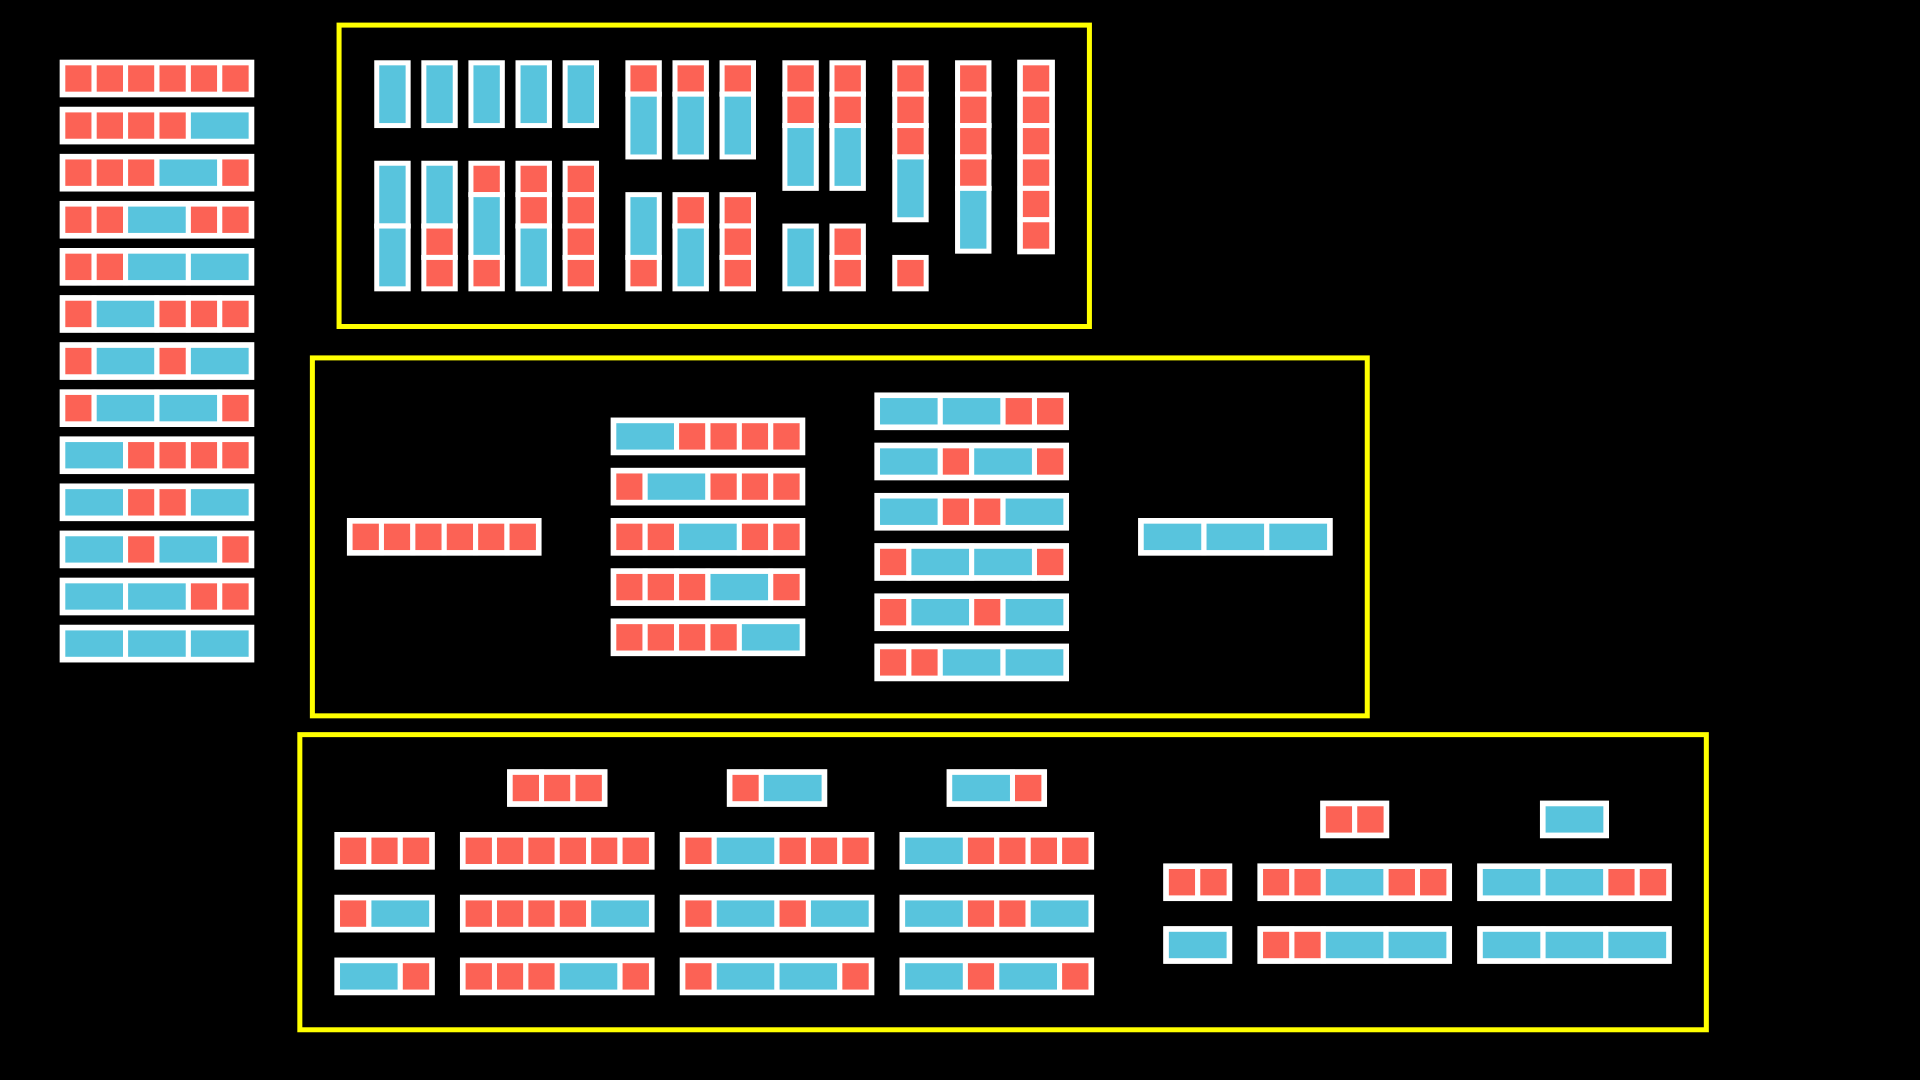

In [47]:
%%manim -s -v WARNING Scene9

from itertools import chain

N = 6

class Scene9(MovingCameraScene):
    def construct(self):
        tilings = FibTilings(N).scale(0.5)
        self.camera.frame.set_height(1.6 * tilings.get_height() + 1)
        tilings.move_to(self.camera.frame.get_corner(UL) + 0.5 * DR, aligned_edge = UL)
        self.add(tilings)
        self.wait()
        
        tilings1 = FibTilings(N).rotate(- 90 * DEGREES).scale(0.5)
        groups = tilings1.sum_groups()
        
        groups.arrange_in_grid(rows = 1, flow_order="ld")
        for i, g in enumerate(reversed(groups)):
            if i < len(groups) - 1:
                rec_piece = VGroup()
                for tiling in g:
                    tiling.remove(tiling.background)
                    for tile in tiling.tiles[i+1:]:
                        rec_piece.add(tile)
                rec_piece.shift(DOWN * 0.3)
#         tilings1.rotate(90 * DEGREES)
        tilings1.move_to(tilings.get_corner(UR) + RIGHT, aligned_edge = UL)
        self.add(tilings1)
        self.add(SurroundingRectangle(tilings1, buff=0.3))
        self.wait()
        
        tilings2 = FibTilings(N).scale(0.5)
        groups = VGroup()
        for k in range(N // 2 + 1):
            group = VGroup(*reversed([t for t in tilings2.tilings if t.lengths.count(2) == k]))
            group.arrange_in_grid(cols = 1, buff = 0.15)
            groups.add(group)
        groups.arrange(buff = 0.6)
        groups.shift(0.6 * RIGHT + 0.2 * UP)
        
        tilings2.next_to(tilings1, DOWN, buff = 0.85).shift(RIGHT)
        self.add(tilings2)
        self.add(SurroundingRectangle(tilings2, buff=0.3))
        self.wait()
        
        big_square = VGroup(*[FibTiling(N) for _ in range(fib_num[N // 2] ** 2)])
        k = 0
        for i in fib_sequence(N // 2):
            for j in fib_sequence(N // 2):
                big_square[k].add_tiles(j + i)
                k += 1    
        big_square.scale(0.5).arrange_in_grid(cols = fib_num[N // 2])
        big_square.shift(RIGHT * 0.5 + UP * 0.5)
        big_rows = FibTilings(N // 2).scale(0.5)
        for i, row in enumerate(big_rows.tilings):
            row.next_to(big_square[fib_num[N // 2] * i], LEFT)
        big_cols = FibTilings(N // 2).scale(0.5)
        for i, col in enumerate(big_cols.tilings):
            col.next_to(big_square[i], UP)
    
                
        bigs = VGroup(big_square, big_rows, big_cols)

        small_square = VGroup(*[FibTiling(N) for _ in range(fib_num[N // 2 - 1] ** 2)])
        k = 0
        for i in fib_sequence(N // 2 - 1):
            for j in fib_sequence(N // 2 - 1):
                small_square[k].add_tiles(j + '2' + i)
                k += 1    
        small_square.scale(0.5).arrange_in_grid(cols = fib_num[N // 2 - 1])
        small_square.to_edge(DOWN).shift(UP * 0.5)
        small_rows = FibTilings(N // 2 - 1).scale(0.5)
        for i, row in enumerate(small_rows.tilings):
            row.next_to(small_square[fib_num[N // 2 - 1] * i], LEFT)
        small_cols = FibTilings(N // 2 - 1).scale(0.5)
        for i, col in enumerate(small_cols.tilings):
            col.next_to(small_square[i], UP)
        smalls = VGroup(small_square, small_rows, small_cols)
        
        bigs.next_to(tilings2, DOWN).shift(DOWN * 0.5 + LEFT)
        smalls.next_to(bigs, RIGHT, buff = 0.6)
        
        self.add(bigs, smalls, SurroundingRectangle(VGroup(bigs, smalls), buff=0.3))

C:\Users\Eric\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: This method is not guaranteed to stay around. Please prefer getting the attribute normally.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Eric\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: This method is not guaranteed to stay around. Please prefer setting the attribute normally or with Mobject.set().
  # This is added back by InteractiveShellApp.init_path()


[08/30/21 21:36:49] INFO                                             ]8;id=1630384609.4940648-553288;file://C:\Users\Eric\Anaconda2\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:597
                             File ready at                                                   
                             'C:\Users\Eric\manim\manim                                      
                             projects\media\images\manim                                     
                             projects\Thumbnail_ManimCE_v0.8.0.png'

                    INFO     Rendered Thumbnail                                  ]8;id=1630384609.4940648-288148;file://C:\Users\Eric\Anaconda2\lib\site-packages\manim\scene\scene.py\scene.py]8;;\:229
                             Played 0 animations

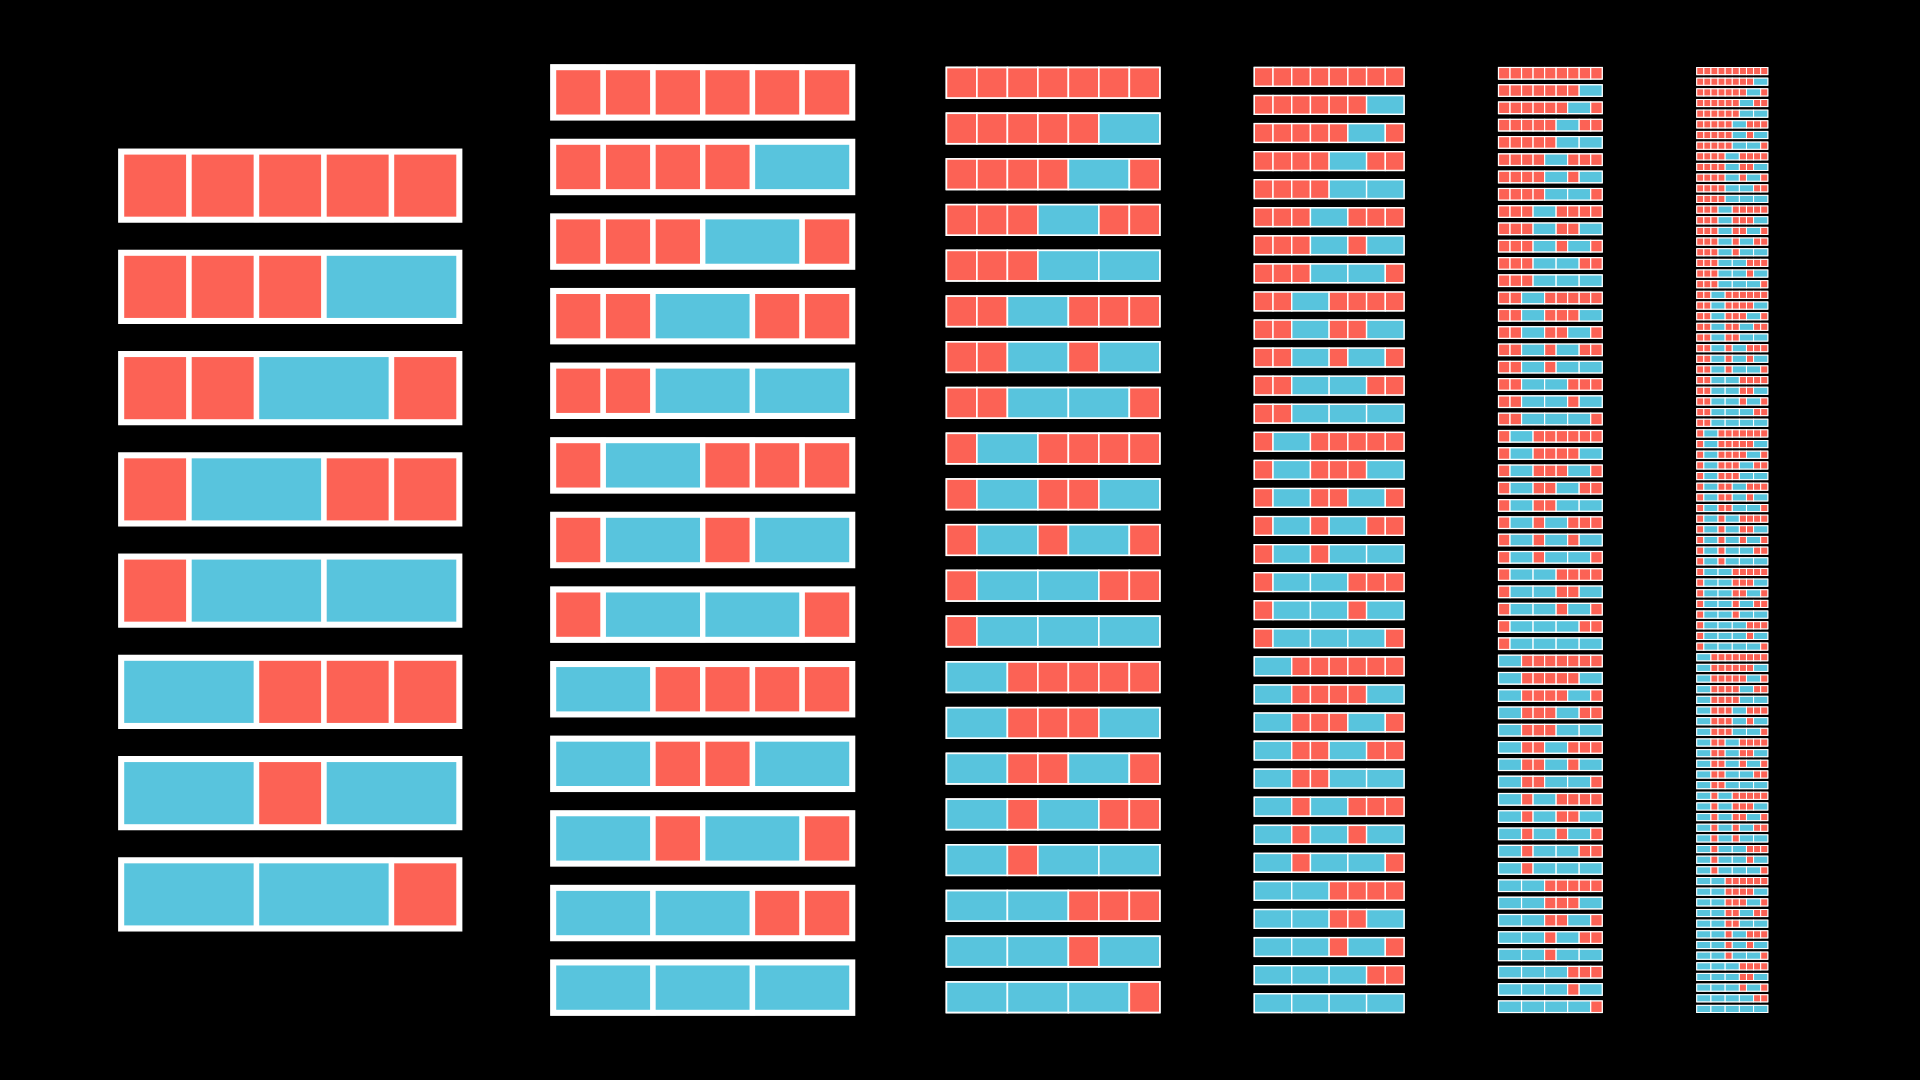

In [52]:
%%manim -s Thumbnail

from itertools import chain

class Thumbnail(MovingCameraScene):
    def construct(self):
        tiling = FibTilings(5)
        tiling.to_edge(LEFT).shift(RIGHT * 0.4)
        self.add(tiling)
        for i in range(6, 11):
            new_tiling = FibTilings(i)
            new_tiling.set_height(min(new_tiling.get_height(), self.camera.frame.get_height() - 1))
            for t in new_tiling.tilings:
                if i >= 7:
                    for tile in t.tiles:
                        tile.stroke_width = 1.2 * 0.85 ** (i-7)
                    t.background.stroke_width = 1.2 * 0.85 ** (i-7)
            new_tiling.next_to(tiling, buff=0.7)
            self.add(new_tiling)
            tiling = new_tiling